# SegnetLite

In [1]:
#!pip install tensorflow xarray numpy wget
#!wget https://raw.githubusercontent.com/pazolka/sun-et-al-2019/main/stages.py
#!wget https://raw.githubusercontent.com/pazolka/sun-et-al-2019/main/full_models.py
#!wget https://raw.githubusercontent.com/pazolka/sun-et-al-2019/main/loss.py

import numpy as np
import xarray as xr

from keras.models import Model
from keras.optimizers import SGD
import tensorflow as tf
from stages import stage1
from full_models import segnetlite_full
from loss import custom_loss

from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint

2024-06-26 14:05:59.034719: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 14:05:59.056485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 1. Shallow learning (Stage 1)
For Unet and SegnetLite models, stage I shallow learning includes a single convolutional layer with 16 filters for each type of predictors, the outputs of which are then merged and provided as inputs to the respective deep learning model.

In [2]:
stage1_model = stage1(16)

stage1_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 masking (Masking)           (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                              

#### 2. SegnetLite

In [3]:
#segnetlite_model = segnetlite((128,128,48))
#segnetlite_model.summary()

#### 3. Combined model (Stage 2)

In [4]:
#full_model = Model(inputs=stage1_model.inputs, outputs=segnetlite_model(stage1_model.outputs))
full_model = segnetlite_full(16)
full_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 128, 128, 16)         448       ['input_4[0][0]']             
                                                                                            

In [5]:
full_model.compile(optimizer = SGD(learning_rate = 0.01, weight_decay=1e-6, momentum=0.9), loss = custom_loss, metrics = [ 'mean_squared_error' ])

In [6]:
full_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 128, 128, 16)         448       ['input_4[0][0]']             
                                                                                            

#### 4. Model training
Out of a total of 177 monthly data available for the study period, 125 months or 70% is used for training and the rest for testing.

In [7]:
precip_train = np.array([np.load(f'./data/processed_input/precip/image_{i}.npy') for i in range(2,127)])
temp_train = np.array([np.load(f'./data/processed_input/temp/image_{i}.npy') for i in range(2,127)])
twsa_train = np.array([np.load(f'./data/processed_input/twsa/image_{i}.npy') for i in range(2,127)])

precip_test = np.array([np.load(f'./data/processed_input/precip/image_{i}.npy') for i in range(127,177)])
temp_test = np.array([np.load(f'./data/processed_input/temp/image_{i}.npy') for i in range(127,177)])
twsa_test = np.array([np.load(f'./data/processed_input/twsa/image_{i}.npy') for i in range(127,177)])

mismatch_ds = xr.open_mfdataset('./data/mismatch.nc4')
mismatch = mismatch_ds['norm_mismatch'].to_numpy()[..., np.newaxis]
mismatch_train = mismatch[2:127]
mismatch_test = mismatch[127:177]

print(f'Number of training examples = {precip_train.shape[0]}')
print(f'Number of test examples = {precip_test.shape[0]}')

print(f'Training input shape: {precip_train.shape}')
print(f'Training output shape: {mismatch_train.shape}')
print(f'Test input shape: {precip_test.shape}')
print(f'Test output shape: {mismatch_test.shape}')

Number of training examples = 125
Number of test examples = 50
Training input shape: (125, 128, 128, 3)
Training output shape: (125, 128, 128, 1)
Test input shape: (50, 128, 128, 3)
Test output shape: (50, 128, 128, 1)


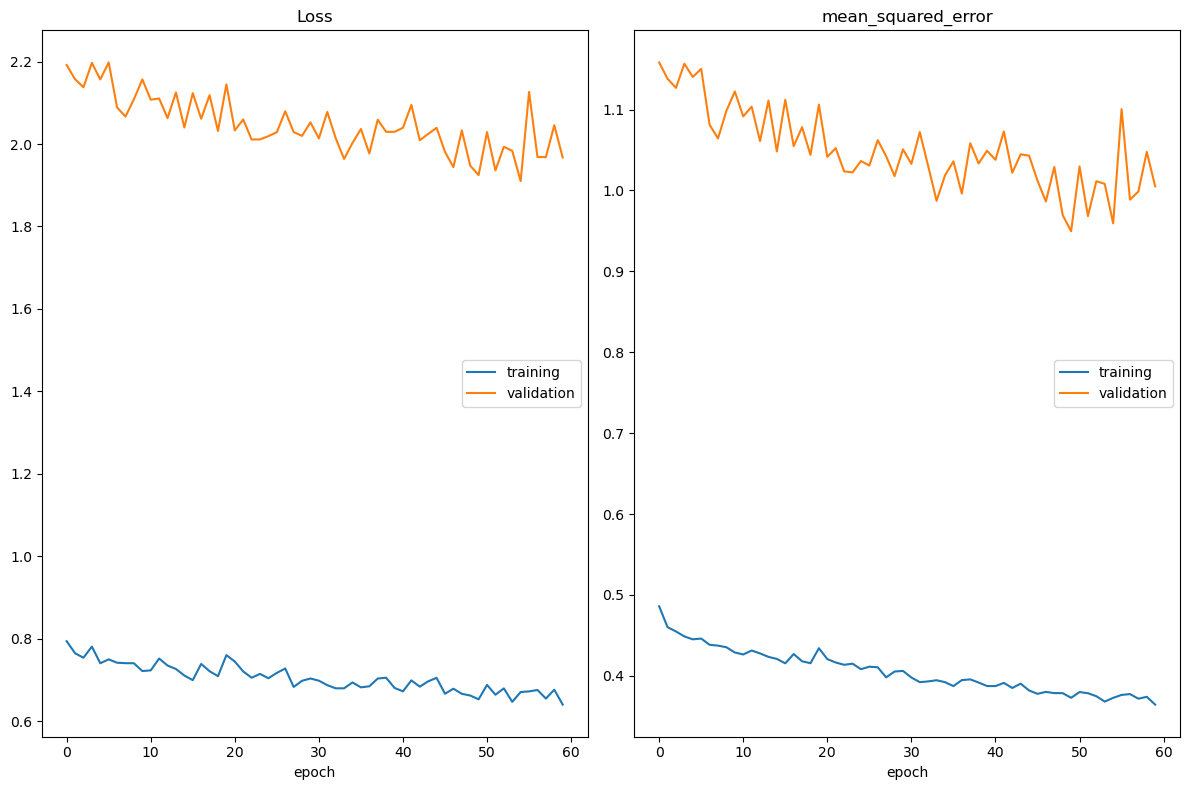

Loss
	training         	 (min:    0.640, max:    0.794, cur:    0.640)
	validation       	 (min:    1.910, max:    2.198, cur:    1.967)
mean_squared_error
	training         	 (min:    0.364, max:    0.486, cur:    0.364)
	validation       	 (min:    0.950, max:    1.158, cur:    1.005)
25/25 [==============================] - 42s 2s/step - loss: 0.6401 - mean_squared_error: 0.3645 - val_loss: 1.9673 - val_mean_squared_error: 1.0050


In [8]:
full_model.fit(x=[precip_train, temp_train, twsa_train],
              y=mismatch_train,
              batch_size=5,
              epochs=60,
              validation_data=([precip_test, temp_test, twsa_test], mismatch_test),
              callbacks=[ModelCheckpoint(filepath='segnet.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1),
                         PlotLossesCallback()],
              verbose=1)

In [9]:
preds = full_model.evaluate([precip_test, temp_test, twsa_test], mismatch_test, batch_size=5)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

10/10 [==============================] - 5s 456ms/step - loss: 1.9673 - mean_squared_error: 1.0050
Loss = 1.967319369316101
Test Accuracy = 1.0049829483032227


In [10]:
pred_mismatch = full_model.predict([precip_test, temp_test, twsa_test], batch_size=5)

10/10 [==============================] - 5s 455ms/step


In [11]:
pred_mismatch_da = xr.DataArray(np.squeeze(pred_mismatch), coords={'time': mismatch_ds['time'][127:177],'lat': mismatch_ds['lat'], 'lon': mismatch_ds['lon']}, dims=['time', 'lat', 'lon'])

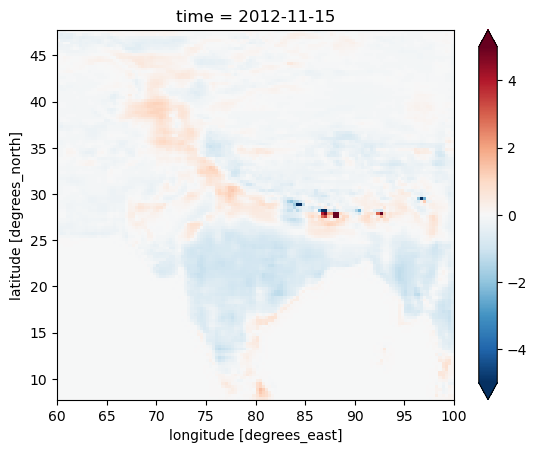

In [12]:
pred_mismatch_da[0,:,:].plot(vmin=-5, vmax=5, cmap='RdBu_r')

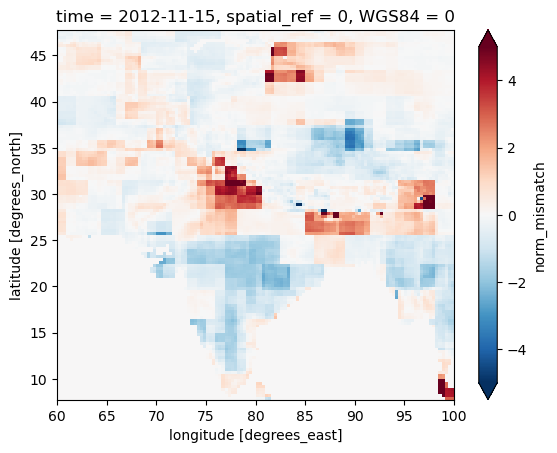

In [13]:
mismatch_ds['norm_mismatch'][127,:,:].plot(vmin=-5, vmax=5, cmap='RdBu_r')

#### 5. Save

In [14]:
# retrieve mean and std of the normalised mismatch to denormalize the output
diff_mean = mismatch_ds['norm_mismatch'].attrs['diff_mean']
diff_std = mismatch_ds['norm_mismatch'].attrs['diff_std']

In [15]:
full_pred_mismatch = full_model.predict([
    np.concatenate((precip_train, precip_test), axis=0),
    np.concatenate((temp_train, temp_test), axis=0),
    np.concatenate((twsa_train, twsa_test))
    ], batch_size=5)

full_pred_mismatch_da = xr.DataArray(np.squeeze(full_pred_mismatch), coords={'time': mismatch_ds['time'][2:177],'lat': mismatch_ds['lat'], 'lon': mismatch_ds['lon']}, dims=['time', 'lat', 'lon'])
denorm_pred_da = full_pred_mismatch_da * diff_std + diff_mean
#denorm_pred_da = full_pred_mismatch_da * (diff_max - diff_min) + diff_min

# save the predicted mismatch
xr.merge([
    full_pred_mismatch_da.to_dataset(name='norm_mismatch_pred'),
    denorm_pred_da.to_dataset(name='mismatch_pred')
]).to_netcdf('./data/segnetlite_output.nc4')

35/35 [==============================] - 17s 480ms/step
